In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, kernel
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

In [3]:
a = np.array([1,2,3,4,5,6])
a[:-2]

array([1, 2, 3, 4])

In [2]:
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [3]:
data[data['ptl_idx']==5]

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste
143,5,1,0,1,0,50,0.1,10.0,0.0,0,96.965446,4.137914
144,5,5,10,5,10,15,0.1,10.0,0.0,0,115.724663,9.195363
145,5,5,20,5,20,15,0.1,10.0,0.0,0,131.265503,12.873509
146,5,5,40,5,40,15,0.1,10.0,0.0,0,154.160944,10.114900
147,5,5,50,5,50,15,0.1,10.0,0.0,0,156.368508,25.747018


In [4]:
data[data['ptl_idx']==6]

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste
148,6,1,0,1,0,50,0.1,-10.0,0.0,0,71.683545,7.390236
149,6,5,10,5,10,15,0.1,-10.0,0.0,0,61.246579,10.161574
150,6,5,20,5,20,15,0.1,-10.0,0.0,0,68.821571,8.312272
151,6,5,40,5,40,15,0.1,-10.0,0.0,0,153.994039,28.637164
152,6,5,50,5,50,15,0.1,-10.0,0.0,0,171.270458,18.935736


In [79]:
data_stdp = data[data['ptl_idx'].isin([1])]

In [82]:
data = [int(data_stdp.iloc[i]['dt1']/2) for i in range(len(data_stdp))]

In [83]:
data

[-51,
 -37,
 -40,
 -33,
 -31,
 -32,
 -21,
 -12,
 -12,
 -7,
 -8,
 -10,
 -6,
 -4,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -1,
 -1,
 0,
 1,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 8,
 7,
 12,
 13,
 17,
 28,
 38,
 43,
 47]

In [ ]:
data_stdp = data[data['ptl_idx']==1]
plt.plot(data_stdp['dt1'], data_stdp['dw_mean'], 'o')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


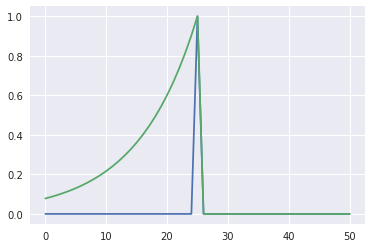

In [95]:
kernel_test = kernel.KernelGen()
plt.plot(kernel_test.dot_ker)
plt.plot(kernel_test.uni_exp_ker('left'))

In [96]:
ker_bi = kernel_test.uni_exp_ker('left')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


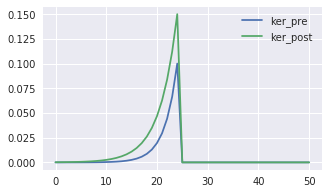

In [98]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()
ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=5, scale=0.1)
ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=7, scale=0.15)
ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=10, scale=0.1)
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
#plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.legend()

In [28]:
with tf.Graph().as_default():
    
    x = tf.placeholder(shape=[51,1], dtype=tf.float32)
    kernel = tf.placeholder(shape=[51, 1], dtype=tf.float32)
    
    x_exp = tf.expand_dims(x, 0)
    kernel_exp = tf.expand_dims(kernel, 2)
    y = tf.squeeze(tf.nn.conv1d(value=x_exp, filters=kernel_exp, stride=1, padding='SAME'))
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        x_out, y_out = sess.run([x, y], feed_dict={x: kernel_test.dot_ker, kernel: kernel_test.bilat_ker})
        
plt.plot(x_out)
plt.plot(y_out)

AttributeError: 'KernelGen' object has no attribute 'bilat_ker'

Test the convolution effect

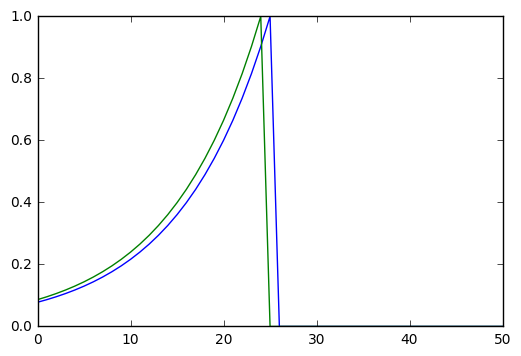

In [6]:
# Create a one side exponential kernel
ker_test = kernel.KernelGen()
kernel_uni = ker_test.uni_exp_ker(side='left')
kernel_uni_shift = ker_test.uni_exp_ker(if_shift=True,side='left')

plt.plot(kernel_uni)
plt.plot(kernel_uni_shift)

In [11]:
# generate a spike train
spk_test = np.zeros((100,1))
spk_test[20] = 1
spk_test[30] = 1

In [17]:
# Convolve and see the results
with tf.Graph().as_default():
    x = tf.expand_dims(tf.cast(spk_test, tf.float32), axis=0)
    kernel = tf.expand_dims(tf.cast(kernel_uni, tf.float32), axis=1)
    y = tf.nn.conv1d(value=x, filters=kernel, stride=1, padding='SAME')
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        output = sess.run(y)

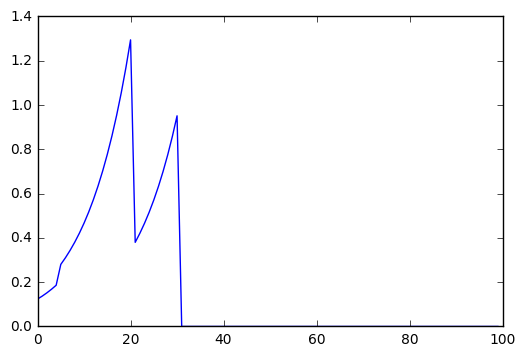

In [21]:
plt.plot(np.squeeze(output))

Test tensor rotation

In [71]:
x_input = np.zeros((5,10,2))
x_input[:,5,:] = 1
# x_input = np.expand_dims(x_input,axis=0)

In [74]:
with tf.Graph().as_default():
    
    x = tf.placeholder(dtype=tf.float32, shape=[None,10,2])
    x1, x2 = tf.unstack(x, axis=2)
    x_shift = tf.concat([tf.expand_dims(x1[:,-1], axis=1), x1[:,:-1]], axis=1)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        x_shift_output = sess.run(x_shift, feed_dict={x: x_input})

In [75]:
x_shift_output.shape

(5, 10)

In [6]:
test = np.array([10,12,131,131,14,15,116])

In [17]:
test[np.where(np.diff(test) == 0)[0]+1]

array([131])

Validate the high pass convolution

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


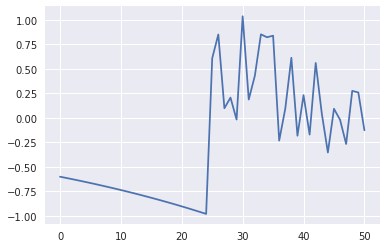

In [3]:
test_ker = kernel.KernelGen()
x = np.random.normal(loc=0.0, scale=0.5, size=test_ker.kernel_post.shape)
x[:25] = 0
x = x + test_ker.kernel_post
x = x.reshape((1,-1))
plt.plot(x[0])

In [4]:
x.shape

(1, 51)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


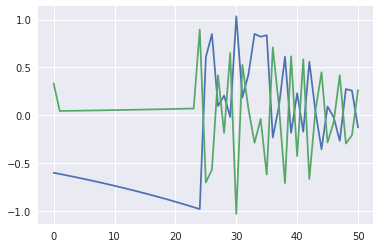

In [32]:
with tf.Graph().as_default():
    x_ = tf.placeholder(dtype=tf.float32, shape=x.shape)
    hp_ker = tf.get_variable(name='hp_ker', shape=[3,1], initializer=tf.constant_initializer(np.array([1, -2, 1]).reshape(-1,1)))
    x_hp = tf.nn.conv1d(tf.expand_dims(input=x_, axis=2), tf.expand_dims(hp_ker, axis=2), stride=1, padding='SAME')
    loss = tf.nn.l2_loss(x_hp)
    trainer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    epoch = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        x_out = sess.run(x_hp, feed_dict={x_: x})
        
        for i in range(epoch):
            sess.run(trainer, feed_dict={x_: x})
        
        x_trained = sess.run(x_hp, feed_dict={x_: x})
        
        
plt.plot(x[0])
plt.plot(np.squeeze(x_trained))

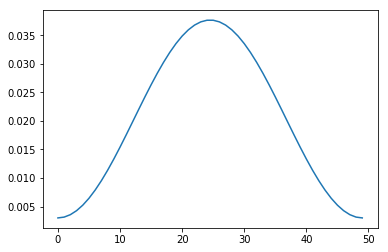

In [12]:
# Test hamming window to let it produce the results
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

% matplotlib inline

with tf.Graph().as_default():
    window = signal.hamming(11)
    window = tf.constant(window / np.sum(window), dtype=tf.float32)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        window_inst = sess.run(window)
    
plt.plot(window_inst)
